In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import glob
import numpy as np
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import metpy.units as units
from scipy.ndimage import uniform_filter
import wrf
import netCDF4 as nc
import tqdm
import pandas as pd
import cartopy
import shapely
from cartopy import geodesic
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage import gaussian_filter
import warnings
warnings.simplefilter("ignore")

In [2]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def synoptic_diagnostics(domain, time, wb_hgt=850, smoothing=4):

    lon1, lat1, lon2, lat2 = domain

    #Calculate the wet bulb potential temperature gradient
    fq=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/q/"+time.strftime("%Y")+"/q_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                   .sel({"time":time.replace(minute=0), "level":slice(wb_hgt,wb_hgt)}).sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)}).metpy.assign_crs(grid_mapping_name='latitude_longitude').q#.metpy.parse_cf("q")
    ft=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/t/"+time.strftime("%Y")+"/t_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                   .sel({"time":time.replace(minute=0), "level":slice(wb_hgt,wb_hgt)}).sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)}).metpy.assign_crs(grid_mapping_name='latitude_longitude').t#.metpy.parse_cf("t")
    fdp = mpcalc.dewpoint_from_specific_humidity(wb_hgt*units.units.hectopascal, ft, fq)

    p3d = xr.DataArray(data = np.ones(ft.shape) * wb_hgt*100, coords=ft.coords, dims=ft.dims, attrs={"units":"Pa"})
    wb = wrf.wetbulb(p3d, ft, fq, meta=True)
    wb_pot = mpcalc.potential_temperature(p3d, wb).isel({"level":0})
    dlat, dlon = mpcalc.gradient(wb_pot.coarsen({"latitude":smoothing, "longitude":smoothing},boundary="pad").mean())
    wb_pot_grad = np.sqrt(np.square(dlat) + np.square(dlon)).metpy.convert_units("K/km")

    #Calculate the 500 hPa geostrophic vorticity
    fz=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/z/"+time.strftime("%Y")+"/z_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                .sel({"time":time.replace(minute=0), "level":slice(500,500)})\
                .sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)})\
                .metpy.assign_crs(grid_mapping_name='latitude_longitude').z\
                .coarsen({"latitude":smoothing, "longitude":smoothing}, boundary="pad").mean().isel({"level":0})
    lons, lats = np.meshgrid(fz.longitude, fz.latitude)
    f=mpcalc.coriolis_parameter(lats * units.units.degree)
    laplacian = (mpcalc.laplacian(fz) / f)
    
    return wb_pot_grad, laplacian

def get_point_data(f,lat,lon,r,plot=False,vmin=None,vmax=None,func="abs"):
    lats = f.coords.get("latitude").values
    lons = f.coords.get("longitude").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    a,b = np.where( (dist_km <= r) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(longitude=target_lons, latitude=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    if func=="abs":
        #Return the value of the point with the highest absolute value
        return f_slice.values[np.abs(f_slice).argmax()]
    elif func=="max":
        #Return the maximum value
        return f_slice.values.max()
    elif func=="min":
        #Return the minimum value
        return f_slice.values.min()

In [3]:
details_list = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")
details_list["gust_time_utc"] = pd.DatetimeIndex(details_list.gust_time_utc)
details_list["rid"] = details_list.rid.astype(str)
details_list["stn_id"] = details_list.stn_id.astype(str).str.pad(width=6,side="left",fillchar="0")

#For the purposes of plotting, change rid column to location names
details_list.loc[details_list.rid=="2","rid"] = "Melbourne"
details_list.loc[details_list.rid=="71","rid"] = "Sydney"
details_list.loc[(details_list.rid=="50") | (details_list.rid=="66"),"rid"] = "Amberley"
details_list.loc[details_list.rid=="27","rid"] = "Woomera"

In [4]:
lon1 = 120; lat1 = -44.5; lon2 = 160; lat2 = -15
domain = [lon1,lat1,lon2,lat2]
r=500
wb_hgt=700

rids = []
times = []
laplacians = []
wb_grads = []
lats = []
lons = []
for index, row in tqdm.tqdm(details_list.iterrows()):
    time = row.gust_time_utc.replace(minute=0)
    wb_pot_grad, laplacian = synoptic_diagnostics(domain, time, wb_hgt=wb_hgt, smoothing=4)
    laplacians.append(get_point_data(laplacian,row.lat,row.lon,r,func="min"))
    wb_grads.append(get_point_data(wb_pot_grad,row.lat,row.lon,r,func="max"))    
    times.append(time)
    rids.append(row.rid)
    lats.append(row.lat)
    lons.append(row.lon)
df = pd.DataFrame({"rid":rids, "laplacian":laplacians, "wb_grad":wb_grads, "lat":lats, "lon":lons}, index=times)
df.to_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/synop_stats.csv")

#TODO: Consider coarsening the geopotential grid, before doing the Laplacian (rather than rolling mean)
#Incorperate time dimension and chunk for systematic application

36it [00:29,  1.21it/s]


[0.001 0.004 0.014 0.024 0.034 0.044 0.054]
[0.001 0.004 0.014 0.024 0.034 0.044 0.054]


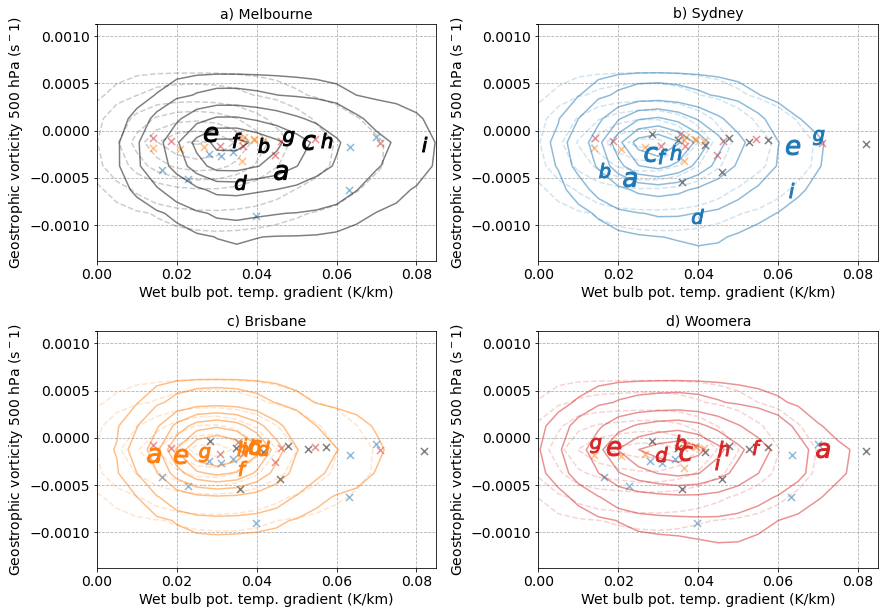

In [5]:
plt.figure(figsize=[14,10])
cnt=1
letter = ["a","b","c","d","e","f","g","h","i"]
letter_cols = {"Melbourne":"k","Sydney":"tab:blue","Amberley":"tab:orange","Woomera":"tab:red"}
locs = [["Melbourne"], ["Sydney"], ["Amberley","Oakey"],["Woomera"]]
titles = ["a) Melbourne", "b) Sydney", "c) Brisbane", "d) Woomera"]
clim = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/era5_synoptic_"+str(r)+"km_wb"+str(wb_hgt)+"_smoothing4_2005_2018.csv")
clim["time"] = pd.DatetimeIndex(clim["time"])
l = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_aus_50.pkl")
clim=l.merge(clim,how="inner",left_on=["date","loc_id"],right_on=["time","loc"])

for i in np.arange(len(locs)):
    ax=plt.subplot(2,2,cnt)
    
    wb = df[np.in1d(df["rid"],locs[cnt-1])]["wb_grad"].values
    laplacian = df[np.in1d(df["rid"],locs[cnt-1])]["laplacian"].values    
    for i in np.arange(len(wb)):
            plt.plot(wb[i],laplacian[i],marker="$"+letter[i]+"$",ls="none",color=letter_cols[locs[cnt-1][0]],ms=15,mew=1)
         
    for index, row in df[~(df.rid==locs[cnt-1][0])].iterrows():
            wb = row["wb_grad"]
            laplacian = row["laplacian"]    
            plt.scatter(wb,laplacian,color=letter_cols[row.rid],alpha=0.5,s=50,marker="x")
            
    plt.xlabel("Wet bulb pot. temp. gradient (K/km)",size=14)
    plt.ylabel("Geostrophic vorticity 500 hPa (s${^-1}$)",size=14)
    plt.gca().grid(ls="--")


    #CLIM PLOT
    c_levels = np.insert(np.arange(0.004,0.064,0.01), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning<2").wb_pot_grad.values, clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning<2").laplacian.values, 
                           bins=[ np.arange(-0.0025,0.105,0.005), np.arange(-0.0015,0.0015,0.00025)])
    H = gaussian_filter(H,1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=ax.contour(x,y,H.T/(H.sum()), levels=c_levels,alpha=0.2,colors=letter_cols[locs[cnt-1][0]],linestyles="--")
    
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(subs="all"))
    
    ax.set_xlim([0,0.085])
    ax.tick_params(labelsize=14)
    plt.title(titles[cnt-1],size=14)
    
    cnt=cnt+1    
print(c_levels)
    
cnt=1
for i in np.arange(len(locs)):
    ax=plt.subplot(2,2,cnt)

    #CLIM PLOT
    c_levels = np.insert(np.arange(0.004,0.064,0.01), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning>=2").wb_pot_grad.values, clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning>=2").laplacian.values, 
                           bins=[ np.arange(-0.0025,0.105,0.005), np.arange(-0.0015,0.0015,0.00025)])
    H = gaussian_filter(H,1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=ax.contour(x,y,H.T/(H.sum()), levels=c_levels,alpha=0.5,colors=letter_cols[locs[cnt-1][0]])
    
    cnt=cnt+1  
print(c_levels)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/wb_laplacian_clim_lightning_"+str(r)+"_"+str(wb_hgt)+".jpeg",bbox_inches="tight",dpi=400)

36it [00:05,  7.00it/s]


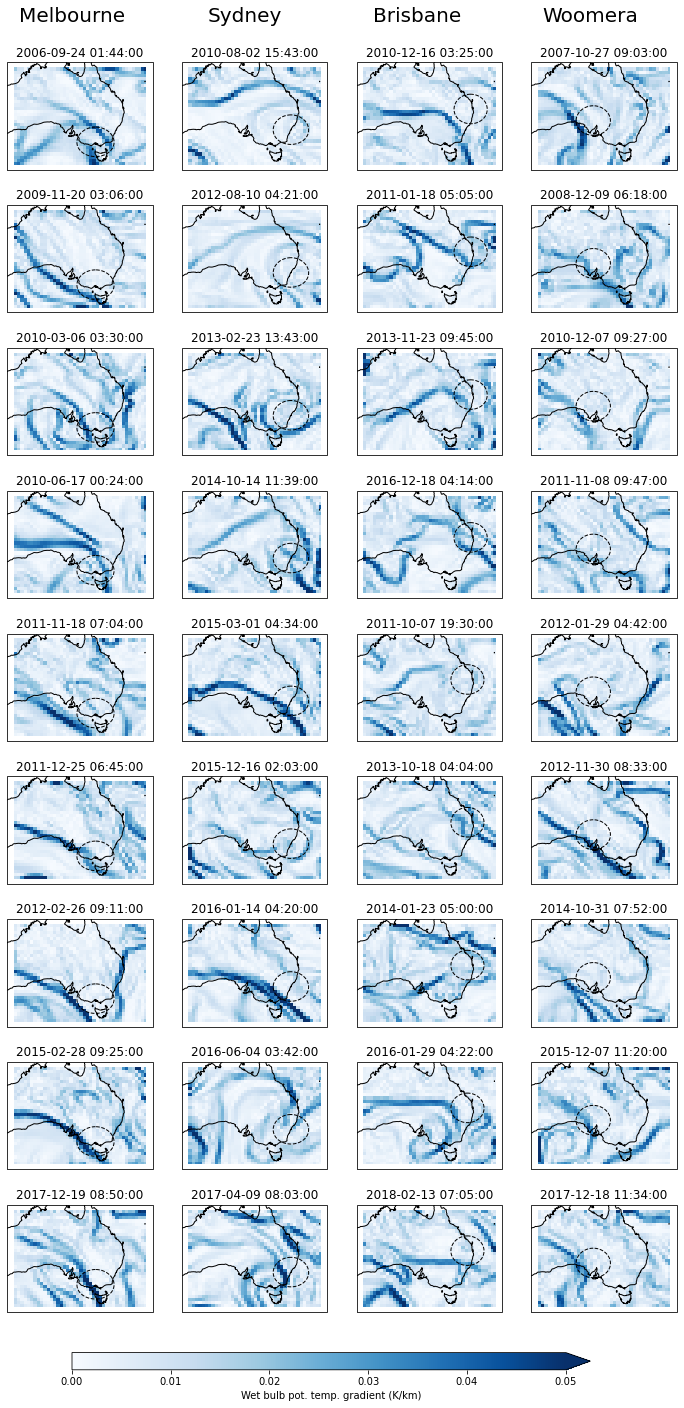

In [6]:
wb_hgt=700
r=500

cnt=0
fig=plt.figure(figsize=[12,24])
locs = list(np.arange(1,9*4,4)) + list(np.arange(2,9*4,4)) + list(np.arange(3,9*4,4)) + list(np.arange(4,9*4+1,4))


for index, row in tqdm.tqdm(details_list.iterrows()):

        wb_pot_grad, laplacian = synoptic_diagnostics(domain, row.gust_time_utc, wb_hgt=wb_hgt, smoothing=4)
    
        ax=plt.subplot(9,4,locs[cnt],projection=ccrs.PlateCarree())
        plot=wb_pot_grad.plot(ax=ax,vmin=0,vmax=0.05,cmap=plt.get_cmap("Blues"),add_colorbar=False)
        ax.coastlines()
        circle_points = geodesic.Geodesic().circle(row.lon, row.lat, r*1000)
        geom = shapely.geometry.Polygon(circle_points)
        ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1,ls="--")
        ax.set_title(row.gust_time_utc)
        
        cnt=cnt+1

plt.subplots_adjust(bottom=0.15)
cb=plt.colorbar(plot,cax=plt.axes([0.2,0.12,0.6,0.01]),orientation="horizontal",extend="max")
cb.set_label("Wet bulb pot. temp. gradient (K/km)")

fig.text(0.2,0.9,"Melbourne",size=20,ha="center")
fig.text(0.4,0.9,"Sydney",size=20,ha="center")
fig.text(0.6,0.9,"Brisbane",size=20,ha="center")
fig.text(0.8,0.9,"Woomera",size=20,ha="center")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/"+"gradT_all_cases"+".jpeg",bbox_inches="tight",dpi=400)

36it [00:04,  7.68it/s]


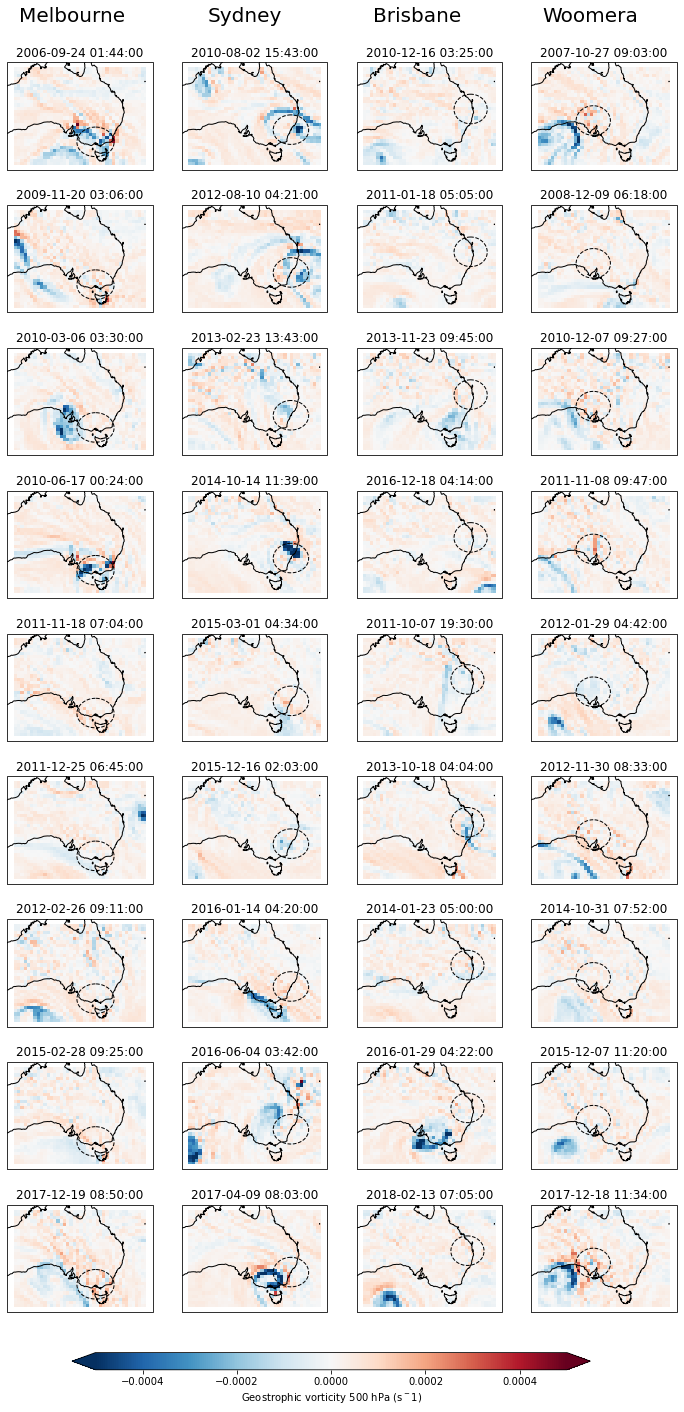

In [7]:
cnt=0
fig=plt.figure(figsize=[12,24])
for index, row in tqdm.tqdm(details_list.iterrows()):
    
        wb_pot_grad, laplacian = synoptic_diagnostics(domain, row.gust_time_utc, wb_hgt=wb_hgt, smoothing=4)

        ax=plt.subplot(9,4,locs[cnt],projection=ccrs.PlateCarree())
        plot=laplacian.plot(ax=ax,vmin=-0.0005,vmax=0.0005,cmap=plt.get_cmap("RdBu_r"),add_colorbar=False)
        ax.coastlines()
        circle_points = geodesic.Geodesic().circle(row["lon"], row["lat"], r*1000)
        geom = shapely.geometry.Polygon(circle_points)
        ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1,ls="--")
        ax.set_title(row.gust_time_utc)
        
        cnt=cnt+1

        # print(get_point_data(wb_pot_grad,details_list[i]["lat"], details_list[i]["lon"],500,plot=True,vmin=0,vmax=0.05))
        # print(get_point_data(laplacian,details_list[i]["lat"], details_list[i]["lon"],500,plot=True,vmin=-0.0005,vmax=0.0005))
        
plt.subplots_adjust(bottom=0.15)
cb=plt.colorbar(plot,cax=plt.axes([0.2,0.12,0.6,0.01]),orientation="horizontal",extend="both")
cb.set_label("Geostrophic vorticity 500 hPa (s${^-1}$)")        

fig.text(0.2,0.9,"Melbourne",size=20,ha="center")
fig.text(0.4,0.9,"Sydney",size=20,ha="center")
fig.text(0.6,0.9,"Brisbane",size=20,ha="center")
fig.text(0.8,0.9,"Woomera",size=20,ha="center")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/"+"gv500_all_cases"+".jpeg",bbox_inches="tight",dpi=400)

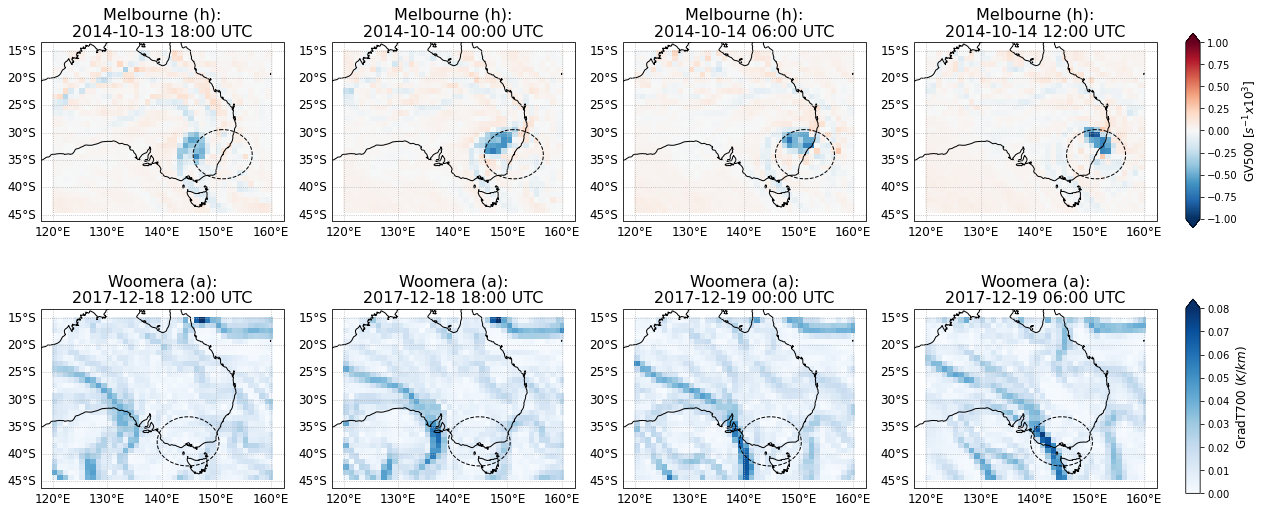

In [8]:
def example_plot_lap(t,ax,lat,lon,cb=False):

    wb_pot_grad, laplacian = synoptic_diagnostics(domain, t, wb_hgt=wb_hgt, smoothing=4)
    p=(laplacian*1000).plot(ax=ax,vmin=-1,vmax=1,cmap=plt.get_cmap("RdBu_r"),add_colorbar=False)
    ax.coastlines()
    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1,ls="--")
    ax.set_title("Melbourne (h):\n"+t.strftime("%Y-%m-%d %H:%M")+" UTC",size=16)
    
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.xlabels_top=False; g.ylabels_right=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER    
    return p

def example_plot_wb(t,ax,lat,lon,cb=False):

    wb_pot_grad, laplacian = synoptic_diagnostics(domain, t, wb_hgt=wb_hgt, smoothing=4)
    p=(wb_pot_grad).plot(ax=ax,vmin=0,vmax=0.08,cmap=plt.get_cmap("Blues"),add_colorbar=False)
    ax.coastlines()
    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1,ls="--")
    ax.set_title("Woomera (a):\n"+t.strftime("%Y-%m-%d %H:%M")+" UTC",size=16)
    
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.xlabels_top=False; g.ylabels_right=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER      
    return p
    
plt.figure(figsize=[20,9])
ax=plt.subplot(2,4,1,projection=ccrs.PlateCarree())
p=example_plot_lap(dt.datetime(2014,10,13,18), ax, -33.9465,151.1731)

ax=plt.subplot(2,4,2,projection=ccrs.PlateCarree())
p=example_plot_lap(dt.datetime(2014,10,14,0), ax, -33.9465,151.1731)

ax=plt.subplot(2,4,3,projection=ccrs.PlateCarree())
p=example_plot_lap(dt.datetime(2014,10,14,6), ax, -33.9465,151.1731)

ax=plt.subplot(2,4,4,projection=ccrs.PlateCarree())
p=example_plot_lap(dt.datetime(2014,10,14,12), ax, -33.9465,151.1731, cb=True)

cax=plt.axes([0.92,0.56,0.01,0.3])
cb=plt.colorbar(p,cax=cax,orientation="vertical",extend="both")
cb.set_label("GV500 [$s^{-1} x 10^{3}$]",fontsize=12)

ax=plt.subplot(2,4,5,projection=ccrs.PlateCarree())
p=example_plot_wb(dt.datetime(2017,12,18,12), ax,-37.6655,144.8321)

ax=plt.subplot(2,4,6,projection=ccrs.PlateCarree())
p=example_plot_wb(dt.datetime(2017,12,18,18), ax,-37.6655,144.8321)

ax=plt.subplot(2,4,7,projection=ccrs.PlateCarree())
p=example_plot_wb(dt.datetime(2017,12,19,0), ax,-37.6655,144.8321)

ax=plt.subplot(2,4,8,projection=ccrs.PlateCarree())
p=example_plot_wb(dt.datetime(2017,12,19,6), ax,-37.6655,144.8321, cb=True)

cax=plt.axes([0.92,0.15,0.01,0.3])
cb=plt.colorbar(p,cax=cax,orientation="vertical",extend="max")
cb.set_label("GradT700 ($K/km$)",fontsize=12)
